PHASE 1: ASK



Business Objective: Conduct a comprehensive analysis of the sales performance of an online store, broken down by products, periods of time, and customers. From this analysis, the aim is to devise effective strategies to boost sales and optimize future inventory management.

In [1]:
# Guiding questions:

# Which are the most sold products?

# Which products generate the most revenue?

# In which months, days, hours of day, are the most revenue generated? 

# Who are the most valuable customers? 

PHASE 2: PREPARE

In [2]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Creating the data frame
sales = pd.read_csv("C:/Users/adria/OneDrive/Documentos/Sales_proyect/Online_Retail.csv", encoding='latin1')

In [4]:
# Checking data types
print(sales.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [5]:
print(sales.describe())
# Outliers were examined in Excel by appplying filters. 

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


PHASE 3: CLEANING

In [6]:
# In order to work with complete months, it is necessary to delimit the sales from 1st December 2010 to 30th November 2011

# First, conversion of column InvoiceDate from object type to datetime type
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], format='%d/%m/%Y %H:%M')

# Now, the filter can be applied
sales_clean = sales[sales['InvoiceDate'].between('2010-12-01', '2011-11-30')]

In [7]:
# I assume most of the NaN values in column CustomerID are uncompleted purchases, so them won´t be considered.
# The rest of NaN values seem to be missing products, them also won´t be considered for this project.

# Delete of NaN values in CustomerID column
sales_clean = sales_clean.dropna(subset=['CustomerID'])

In [8]:
# Count of NaN values before cleaning
nan_count = sales.isna().sum().sum()
print(f'The total amount of NaN values in CustomerID before cleaning is: {nan_count}')

# Count of NaN values after cleaning
nan_count_2 = sales_clean.isna().sum().sum()
print(f'The total amount of NaN values in CustomerID after cleaning is:{nan_count_2}')

The total amount of NaN values in CustomerID before cleaning is: 136534
The total amount of NaN values in CustomerID after cleaning is:0


In [9]:
# Creating new columns
sales_clean['Revenue'] = sales_clean['Quantity'] * sales['UnitPrice'] #Revenue column

sales_clean['InvoiceMonth'] = sales_clean['InvoiceDate'].dt.month     #InvoiceMonth column

sales_clean['InvoiceDay'] = sales_clean['InvoiceDate'].dt.day_name()   #InvoiceDay column

sales_clean['HourofDay'] = sales_clean['InvoiceDate'].dt.hour          #HourofDay column

In [10]:
# Rearrenging the order of columns
new_order = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'Revenue', 'InvoiceDate', 'InvoiceMonth', 'InvoiceDay', 'HourofDay', 'Country', 'CustomerID',]
sales_clean = sales_clean[new_order]

PHASE  4 & 5: ANALYSIS AND SHARE

Monthly revenue:
InvoiceMonth
11    1091886.890
10     974603.590
9      931440.372
5      648251.080
8      616368.000
6      608013.160
3      579964.610
7      574238.481
12     554604.020
1      475074.380
2      436546.150
4      426047.851
Name: Revenue, dtype: float64


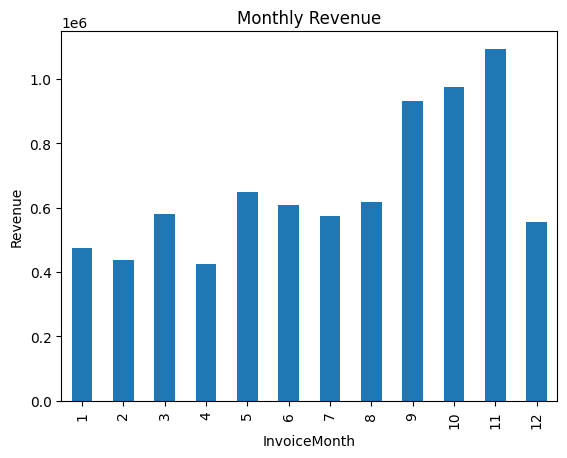

Daily revenue:
InvoiceDay
Thursday     1812903.010
Tuesday      1519534.391
Wednesday    1420965.370
Monday       1217916.981
Friday       1181620.291
Sunday        764098.541
Name: Revenue, dtype: float64


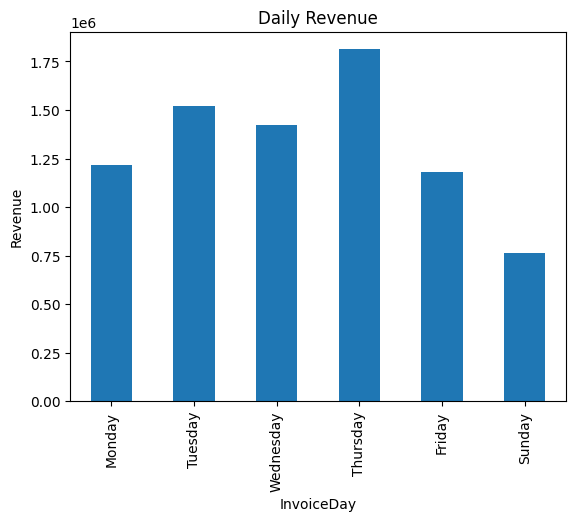

Revenue by hour of the day:
HourofDay
12    1263253.610
10    1114794.561
13    1075601.290
11    1021742.340
14     906073.451
15     854758.880
9      633387.031
16     416465.790
8      263189.530
17     194508.311
18      84614.400
19      42178.600
7       31009.320
20      15958.820
6        -497.350
Name: Revenue, dtype: float64


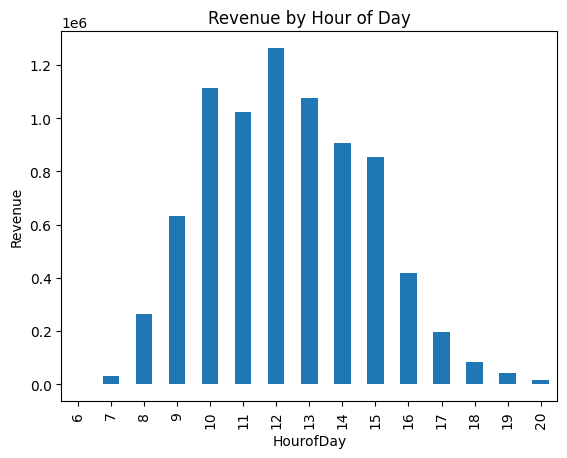

In [22]:
 # Analysis by time

# Monthly revenue 
monthly_revenue = sales_clean.groupby('InvoiceMonth')['Revenue'].sum().sort_values(ascending=False)
print("Monthly revenue:")
print(monthly_revenue)

# Plot
monthly_revenue = monthly_revenue.sort_index()
monthly_revenue.plot(kind='bar')
plt.title('Monthly Revenue')
plt.ylabel('Revenue')
plt.show()

 # Daily revenue 
daily_revenue = sales_clean.groupby('InvoiceDay')['Revenue'].sum().sort_values(ascending=False)
print("Daily revenue:")
print(daily_revenue)

# Plot
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
daily_revenue = daily_revenue.loc[order_of_days]
daily_revenue.plot(kind='bar')
plt.title('Daily Revenue')
plt.ylabel('Revenue')
plt.show()

# Revenue by hour of day
byhour_revenue = sales_clean.groupby('HourofDay')['Revenue'].sum().sort_values(ascending=False)
print("Revenue by hour of the day:")
print(byhour_revenue)

# Plot
byhour_revenue = byhour_revenue.sort_index()
byhour_revenue.plot(kind='bar')
plt.title('Revenue by Hour of Day')
plt.ylabel('Revenue')
plt.show()

Most profitable products:
Description                         StockCode
REGENCY CAKESTAND 3 TIER            22423        128112.07
WHITE HANGING HEART T-LIGHT HOLDER  85123A        91018.51
JUMBO BAG RED RETROSPOT             85099B        80960.40
PARTY BUNTING                       47566         67172.73
POSTAGE                             POST          63475.74
ASSORTED COLOUR BIRD ORNAMENT       84879         54310.48
CHILLI LIGHTS                       79321         43780.14
RABBIT NIGHT LIGHT                  23084         43646.72
PICNIC BASKET WICKER 60 PIECES      22502         39619.50
PAPER CHAIN KIT 50'S CHRISTMAS      22086         36986.96
Name: Revenue, dtype: float64


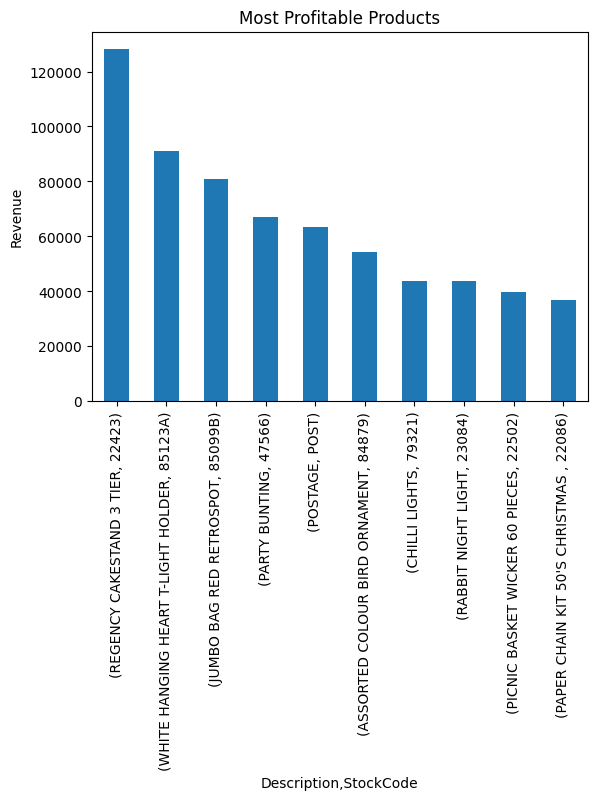

Most sold products: 
Description                         StockCode
WORLD WAR 2 GLIDERS ASSTD DESIGNS   84077        51612
JUMBO BAG RED RETROSPOT             85099B       43874
ASSORTED COLOUR BIRD ORNAMENT       84879        33928
WHITE HANGING HEART T-LIGHT HOLDER  85123A       33093
PACK OF 72 RETROSPOT CAKE CASES     21212        32902
MINI PAINT SET VINTAGE              22492        25481
POPCORN HOLDER                      22197        24803
PACK OF 12 LONDON TISSUES           22616        24660
PACK OF 60 PINK PAISLEY CAKE CASES  21977        23823
RABBIT NIGHT LIGHT                  23084        23081
Name: Quantity, dtype: int64


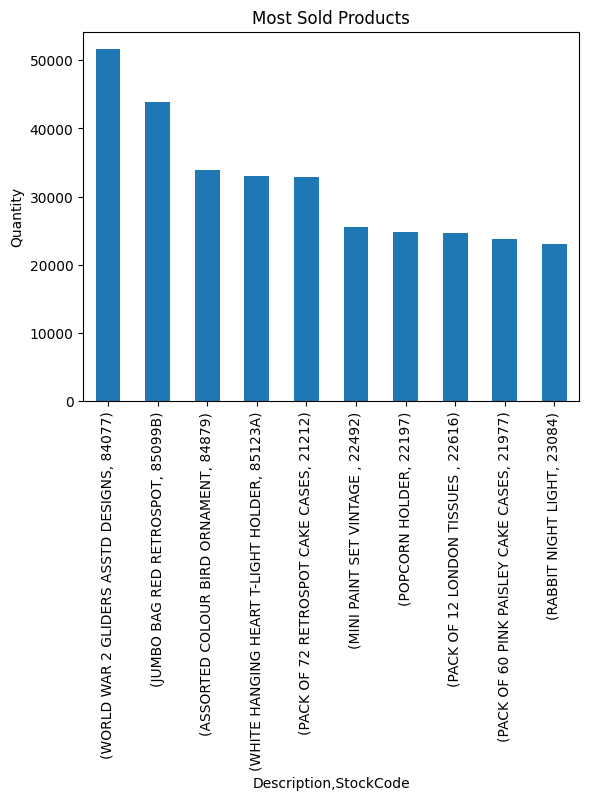

Products in both rankings: 
MultiIndex([(           'JUMBO BAG RED RETROSPOT', '85099B'),
            (     'ASSORTED COLOUR BIRD ORNAMENT',  '84879'),
            ('WHITE HANGING HEART T-LIGHT HOLDER', '85123A'),
            (                'RABBIT NIGHT LIGHT',  '23084')],
           names=['Description', 'StockCode'])


In [20]:
# Analysis of products

# Most profitable products
most_profitable = sales_clean.groupby(['Description','StockCode'])['Revenue'].sum().sort_values(ascending=False).head(10)
print("Most profitable products:")
print(most_profitable)

# Plot
most_profitable.plot(kind='bar')
plt.title('Most Profitable Products')
plt.ylabel('Revenue')
plt.show()

# Most sold products
most_sold = sales_clean.groupby(['Description','StockCode'])['Quantity'].sum().sort_values(ascending=False).head(10)
print("Most sold products:")
print(most_sold)

# Plot
most_sold.plot(kind='bar')
plt.title('Most Sold Products')
plt.ylabel('Quantity')
plt.show()

# Products in both rankings
products_both_rankings = most_sold.index.intersection(most_profitable.index)
print("Products in both rankings:")
print(products_both_rankings)

            Recency Frequency Monetary      
               mean      mean     mean count
RFM_Segment                                 
111           258.5       7.5    126.3   383
112           248.7      10.2    381.5    96
113           233.5       9.7    944.1    23
114           253.5       6.5   5436.7     6
121           249.8      24.7    172.3   111
...             ...       ...      ...   ...
434             8.5      76.8   3681.9    81
441             4.5     117.5    265.1     2
442             8.3     131.7    510.6    22
443             8.2     166.8   1118.7    91
444             7.6     369.0   9296.4   411

[63 rows x 4 columns]


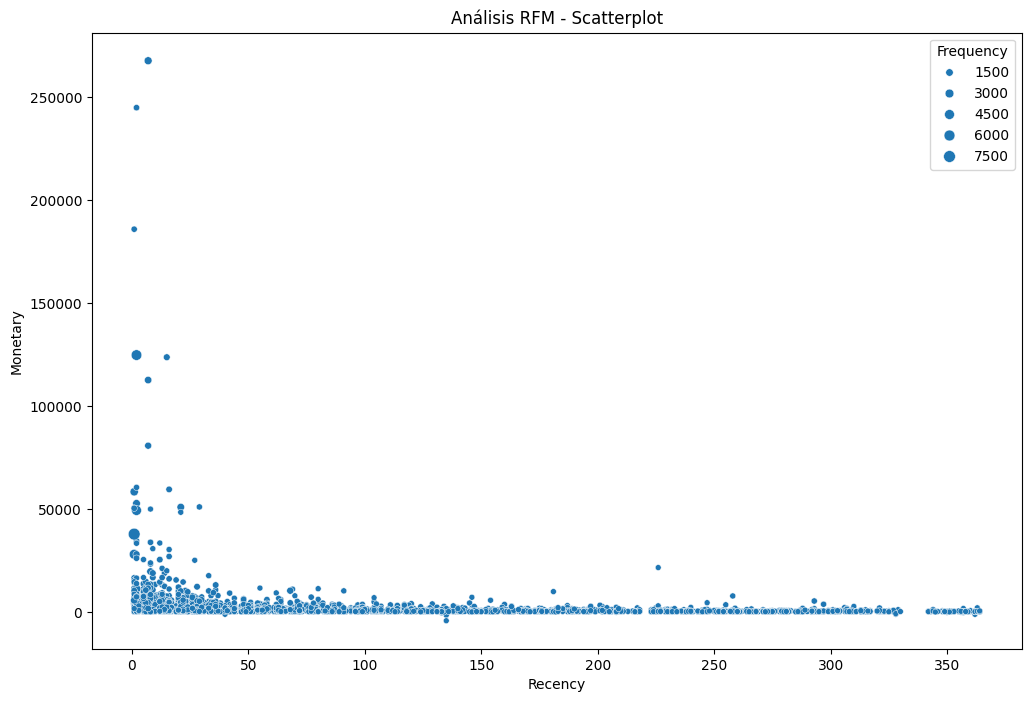

In [13]:
# Analysis RFM (customer behaivor)

# Recency: days since last purchase
snapshot_date = sales_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = sales_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Revenue': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Clasification of RFM
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1))
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=range(1, 5))
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, 5))

# RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Agrupation by segment
rfm_segments = rfm.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
print(rfm_segments)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Recency', y='Monetary', size='Frequency', data=rfm)
plt.title('Análisis RFM - Scatterplot')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()


In [14]:
# Key findings

# The highest revenue-generating months are September, October, and November, while the most profitable days of the week are Tuesday and Thursday, and the peak hours for revenue generation are from 10:00 to 13:59.

# Products wich are both in most sold products and most profitable products are: JUMBO BAG RED RETROSPOT, ASSORTED COLOUR BIRD ORNAMENT,
# WHITE HANGING HEART T-LIGHT HOLDER and RABBIT NIGHT LIGHT.

# High-Value Customers are (RFM Segment = 444, 434), and At-Risk Customers are (RFM Segment = 111, 112, 113).

PHASE 6: ACT

In [15]:
# The top three recomendations to boost sales and optimize future inventory managment are: ......